# Barcode Preprocessing & Detection

### Acknowledgement: Code was referred from <a href='https://pyimagesearch.com/2014/11/24/detecting-barcodes-images-python-opencv/'>here </a> and experimented for optimal result. Credits to pyimagesearch.com.

In [1]:
from importlib import reload
import cv2
import numpy as np
import matplotlib.pyplot as plt

from ipcv import cvlib, scanner, imutil, shape

reload(cvlib)
reload(scanner)
reload(imutil)
reload(shape)

<module 'ipcv.shape' from '/Users/everhett/Projects/python-ws/qr-scanner/ipcv/shape.py'>

In [2]:
# A function to display side-by-side visuals for comparisons and swaps previous and current data for continues processing.
def display_and_swap(data, curr_img, curr_label, display=True):
    # Display the previous and current side-by-side for visual comparison.
    if display:
        plt.figure(figsize=(14, 12))
        plt.subplot(1, 2, 1)
        plt.imshow(data['prev'], cmap='gray')
        plt.title(data['prev_label'])

        plt.subplot(1, 2, 2)
        plt.imshow(curr_img, cmap='gray')
        plt.title(curr_label)

    # Swap data for subsequent execution.
    data['prev'] = curr_img
    data['prev_label'] = curr_label

    data['curr'] = None
    data['curr_label'] = None

    return data

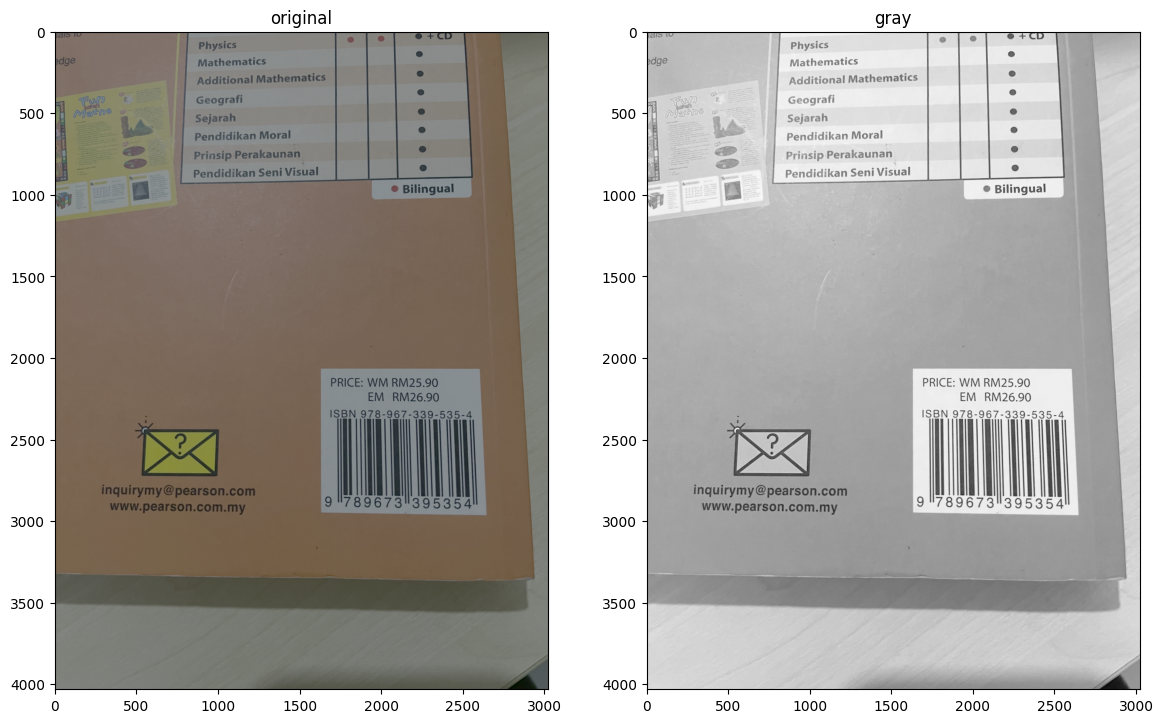

In [3]:
# Load the image as RGB.
# image = cvlib.load_image('../resources/barcode/barcode200.png')
# image = cvlib.load_image('../resources/barcode/barcode160.jpg')
# image = cvlib.load_image('../resources/barcode/barcode112.png')
# image = cvlib.load_image('../resources/barcode/barcode170.jpg')
image = cvlib.load_image('../resources/barcode/barcode111.png')
# image = cvlib.load_image('../resources/barcode/barcode140.jpg')

# This image needs higher dilation [51,7]
# image = cvlib.load_image('../resources/barcode/barcode114.png')

# image = cvlib.load_image('../resources/qr-code/qrcode500.jpg')
# image = cvlib.load_image('../resources/qr-code/qrcode600.jpg')

# Convert the image into gray for processing.
label = 'gray'
curr = cvlib.convert_rgb2gray(image)

# Manually set the data once. The swap_and_display() will take care of this data for subsequent operations.
dat = {}
dat = {'prev': image, 'prev_label': 'original', 'curr': curr, 'curr_label': label}

# The current data is replaced to previous for next operation.
dat = display_and_swap(dat, curr, label)

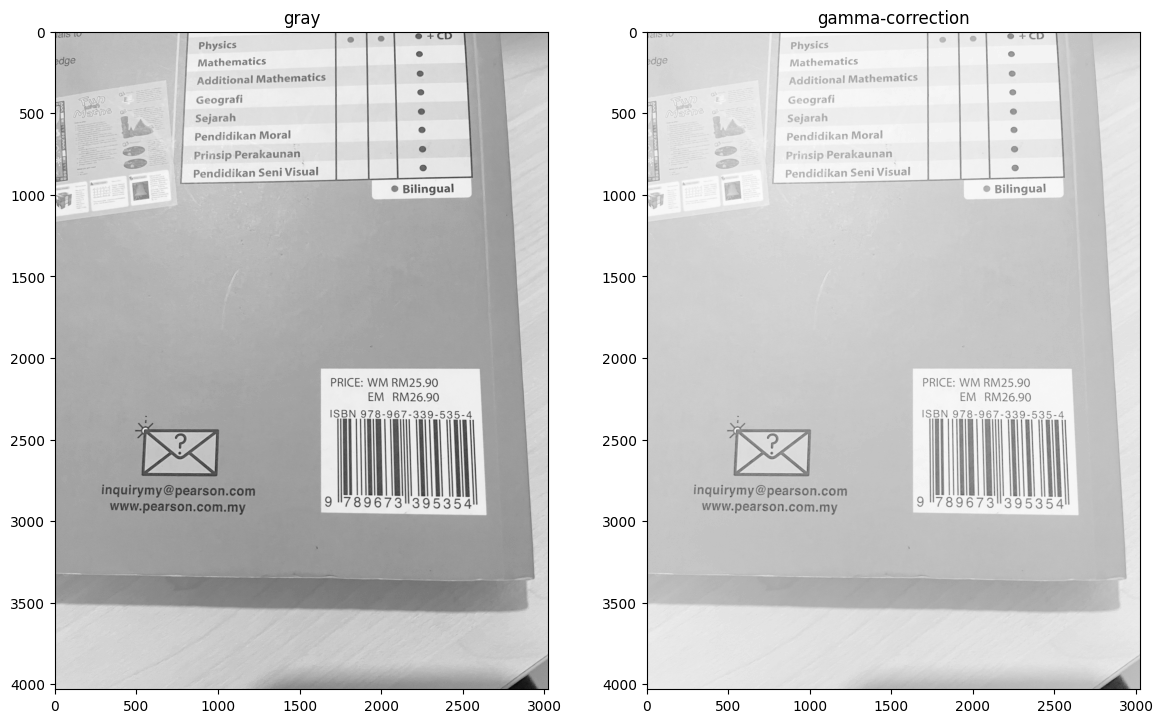

In [4]:
# Correct image's contrast before removing noises.
label = 'gamma-correction'
gamma = 0.5

curr = cvlib.adjust_gamma(dat['prev'], gamma)
# curr = cvlib.adjust_gamma3(dat['prev'], gamma)

# Display and swap for data for next operation.
dat = display_and_swap(dat, curr, label)

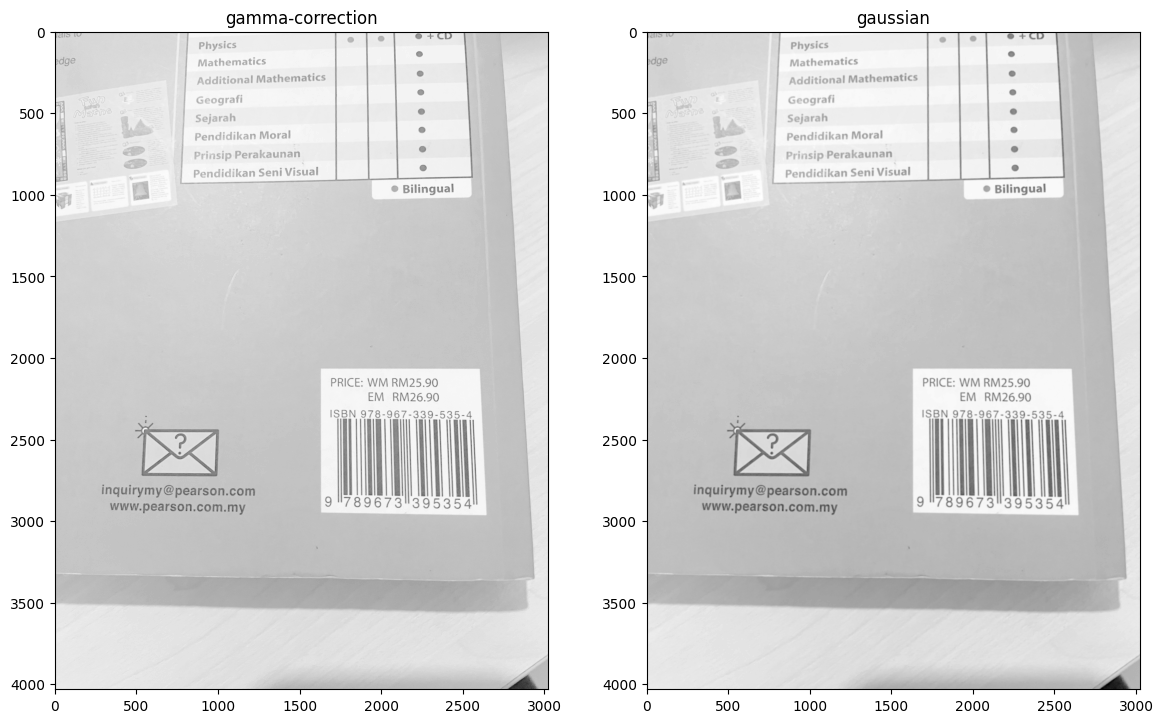

In [5]:
# Gaussian blur to removes noise before processing.
label = 'gaussian'
ksize = (15, 15)
sigma = 2
curr = cvlib.gaussian_blur(dat['prev'], ksize, sigma)

# Display and swap for data for next operation.
dat = display_and_swap(dat, curr, label)

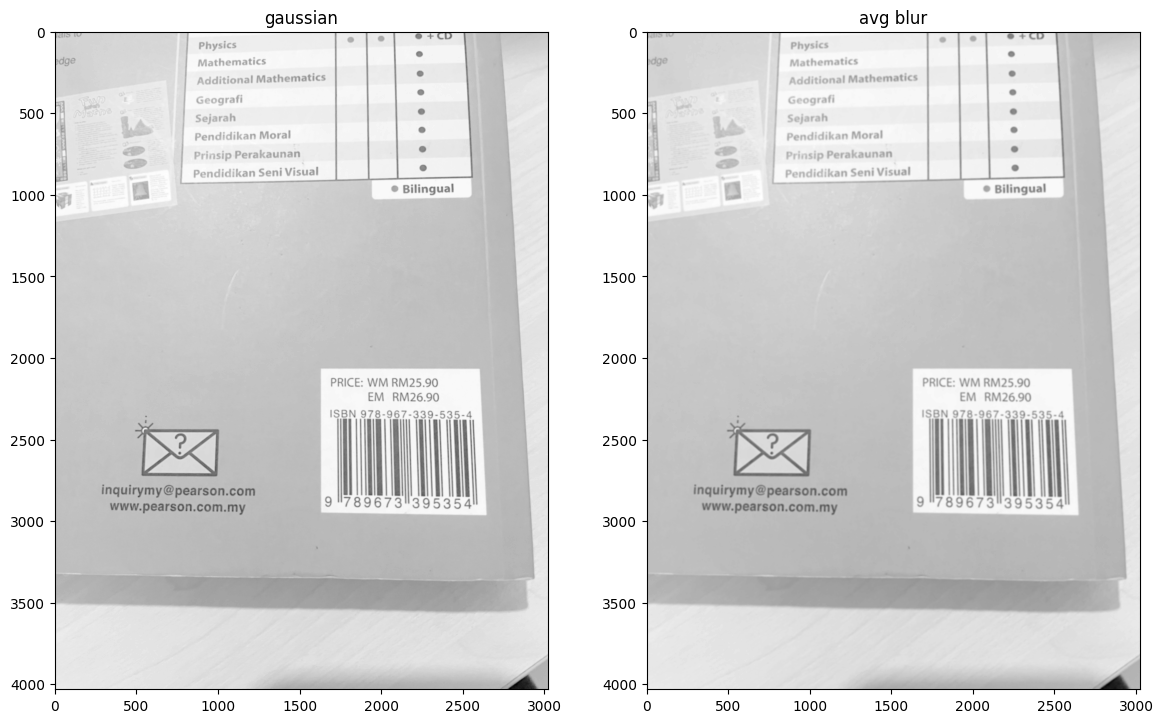

In [6]:
# Average blur
label = 'avg blur'
kernel = [9, 9]
curr = cvlib.average_blur(dat['prev'], kernel)

# Display and swap for data for next operation.
dat = display_and_swap(dat, curr, label)

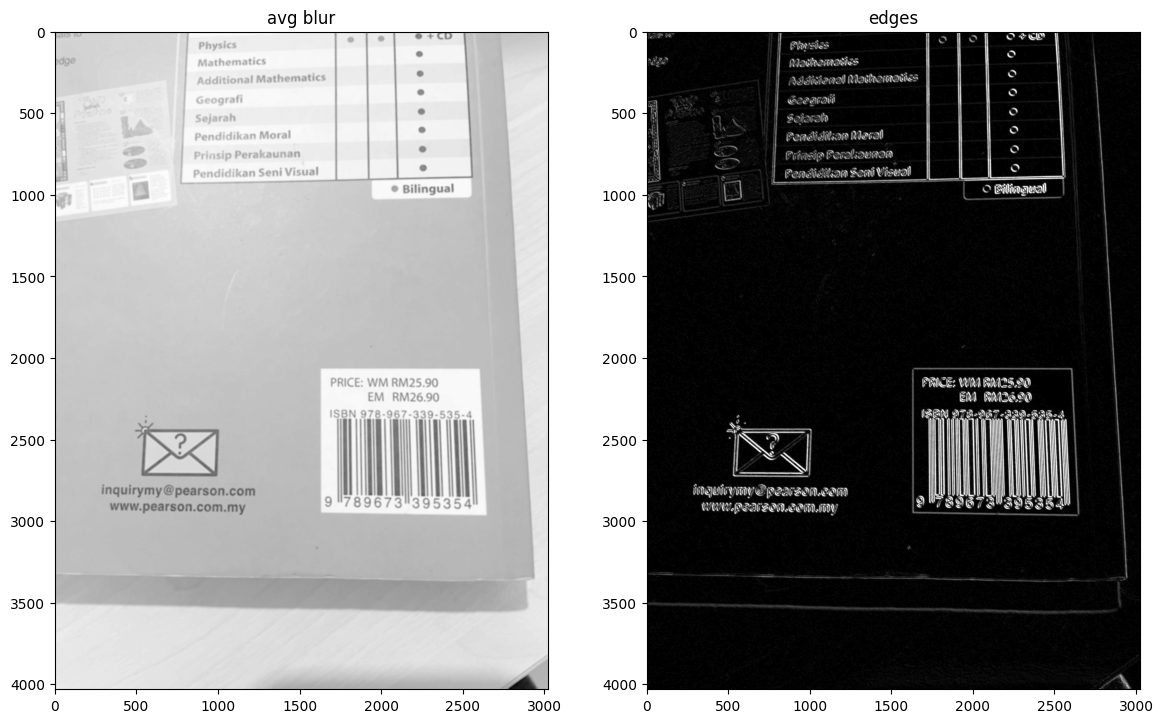

In [7]:
# Detect edges for processing.
label = 'edges'
curr = cvlib.detect_gradient(dat['prev'])

# Display and swap for data for next operation.
dat = display_and_swap(dat, curr, label)

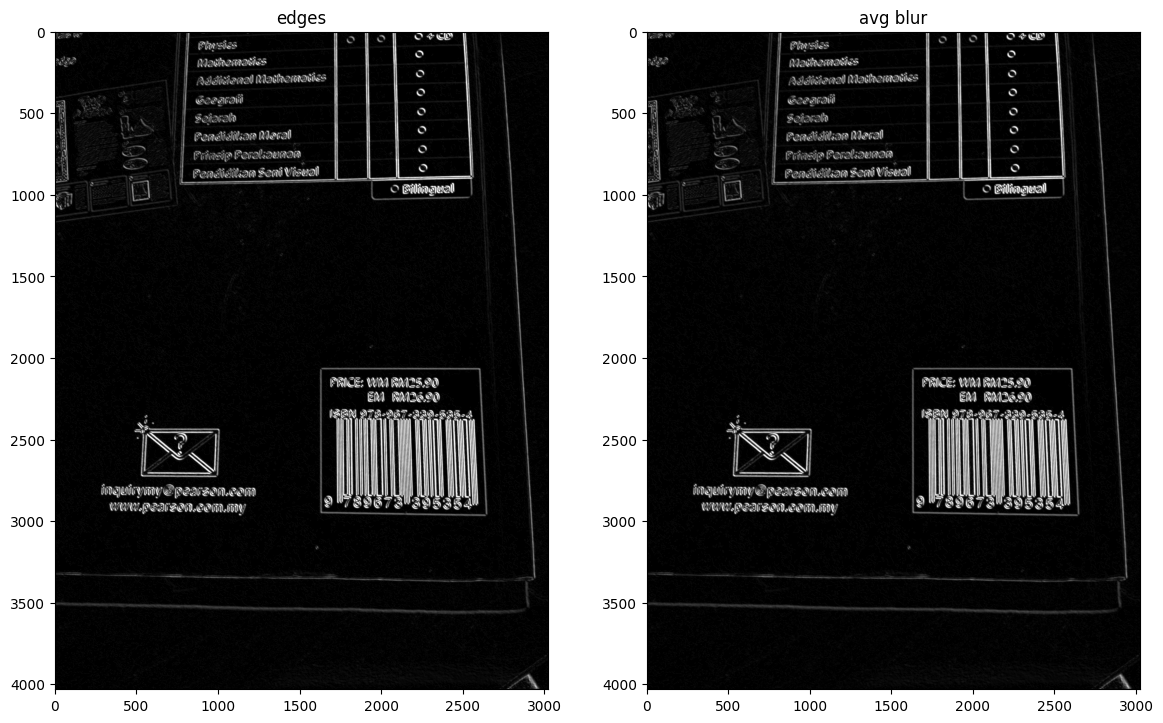

In [8]:
# Average blur
label = 'avg blur'
kernel = [3, 3]
curr = cvlib.average_blur(dat['prev'], kernel)

# Display and swap for data for next operation.
dat = display_and_swap(dat, curr, label)

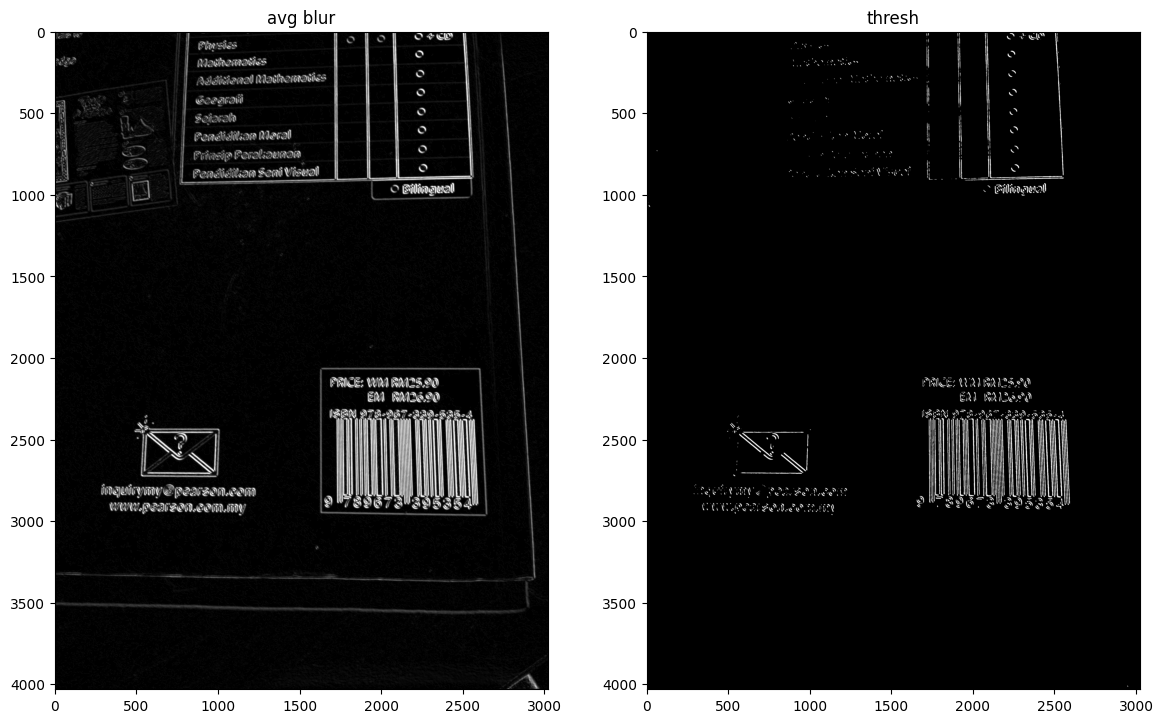

In [9]:
label = 'thresh'
thresh = 200
curr = cvlib.binarize(dat['prev'], thresh)

# Display and swap for data for next operation.
dat = display_and_swap(dat, curr, label)

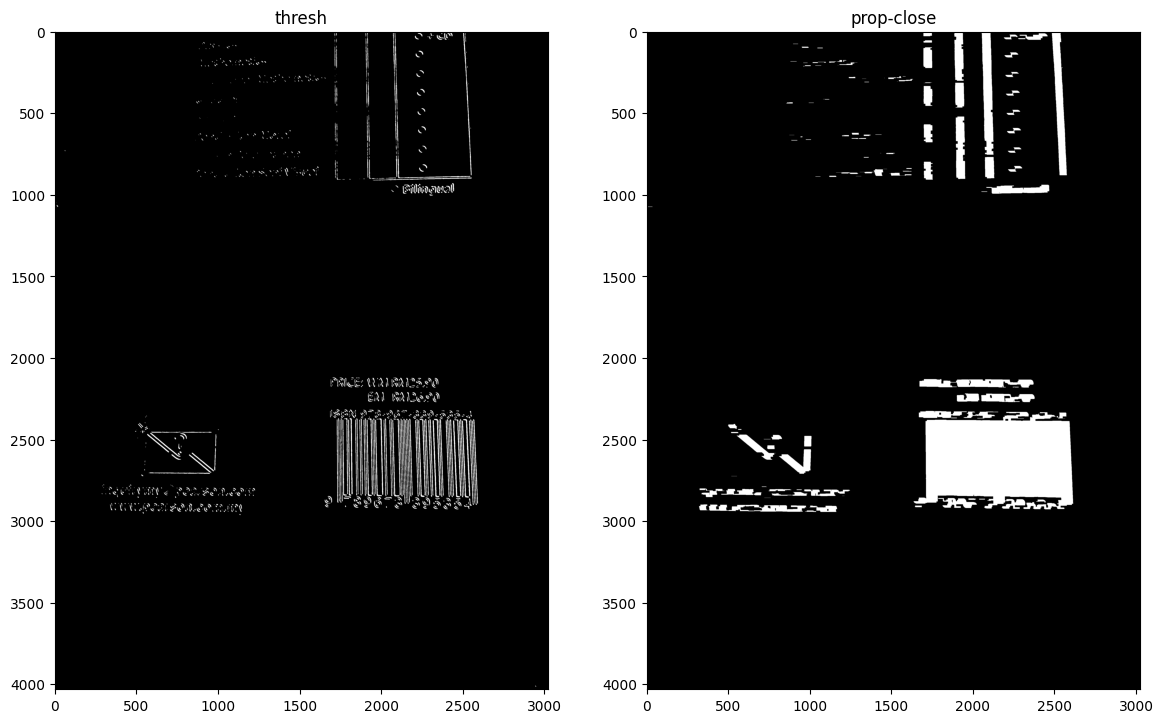

In [10]:
from math import ceil

label = 'prop-close'

dilate_iteration = 20
erode_iteration = 10

# curr = cvlib.morph_proportionate_close(dat['prev'], 18, 9, 3, 2)
# 2:1
# curr = cvlib.morph_proportionate_close(dat['prev'], dilate_iteration, ceil(dilate_iteration / 2), 3, 2)
curr = cvlib.morph_proportionate_close(dat['prev'], dilate_iteration, erode_iteration, 3, 2)

# Display and swap for data for next operation.
dat = display_and_swap(dat, curr, label)

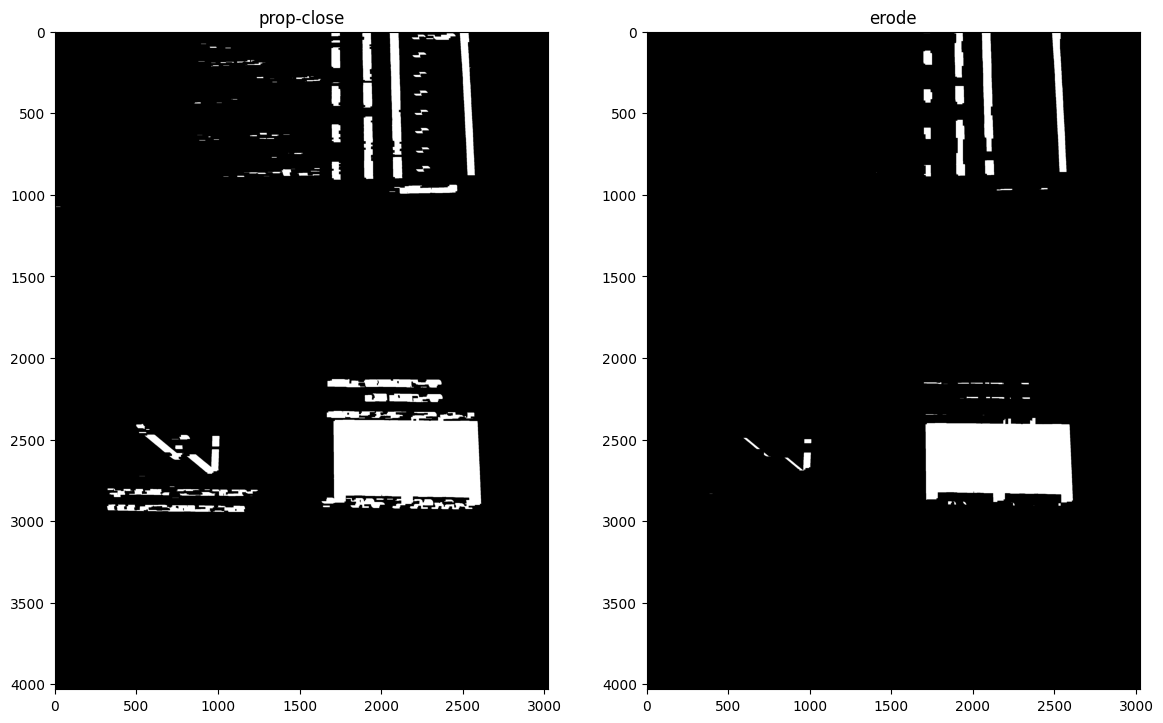

In [11]:
label = 'erode'
# dilate_kernel = (25, 25)
# curr = cvlib.morph_open(dat['prev'], dilate_kernel, 10)
vertical_se = np.ones((5, 1)).astype('uint8')
curr = cvlib.morph_erode_ex(dat['prev'], vertical_se, 10)

# Display and swap for data for next operation.
dat = display_and_swap(dat, curr, label)

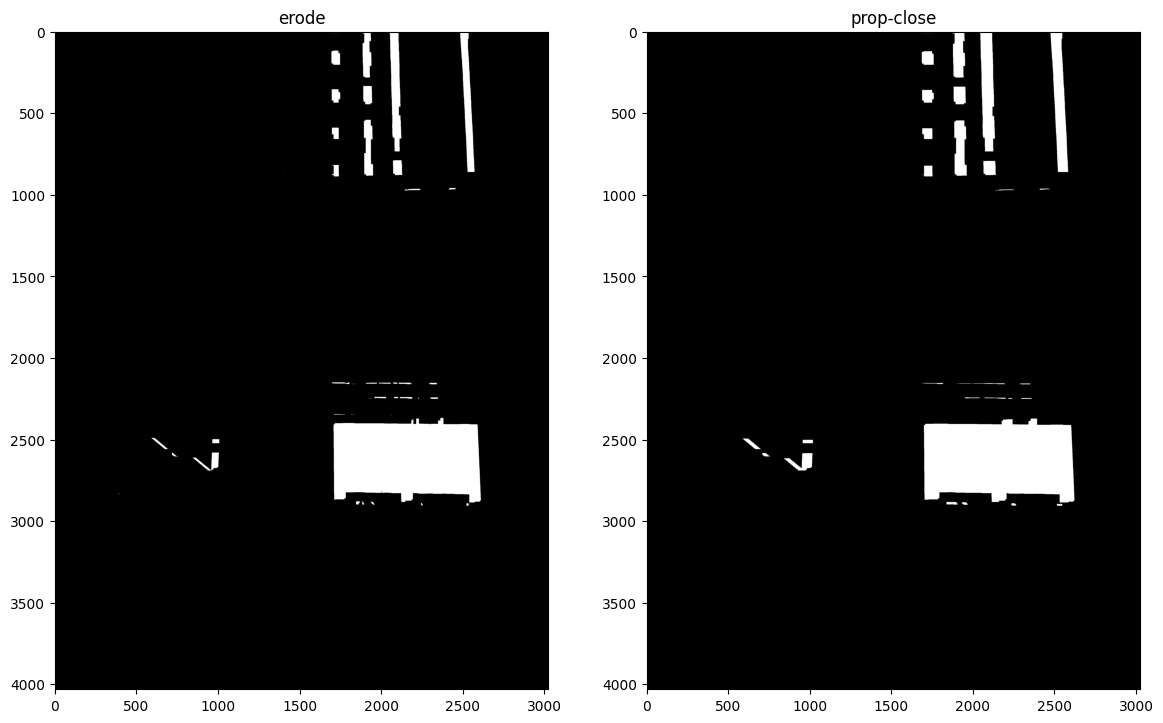

In [12]:
# label = 'dilate'
# dilate_kernel = (15, 15)
# # curr = cvlib.morph_open(dat['prev'], dilate_kernel, 10)
# curr = cvlib.morph_dilate_ex(dat['prev'], vertical_se, 20)
#
# # Display and swap for data for next operation.
# dat = display_and_swap(dat, curr, label)

label = 'prop-close'

curr = cvlib.morph_proportionate_close(dat['prev'], ceil(dilate_iteration / 2), ceil(dilate_iteration / 5), 3, 2)

# Display and swap for data for next operation.
dat = display_and_swap(dat, curr, label)

In [13]:
label = 'contour'
# box = cvlib.get_prominent_contour(dat['prev'])

# Try with find contour
contour = shape.find_rectangle(processed_img=dat['prev'],
                               min_area_factor=0.02,
                               cnt=1,
                               box=False,
                               draw=True,
                               verbose=False)

[1] --Contour       : found=29; min-req-area=243,855.36, max-req-area=8,534,937.60 (0.02 at rate); area should be > 2.00%
[c:6] --Contour     : selected max-area=399,317.00 at rate=3.28, aspect-ratio=1.911950


Decoded barcode : 9789673395354


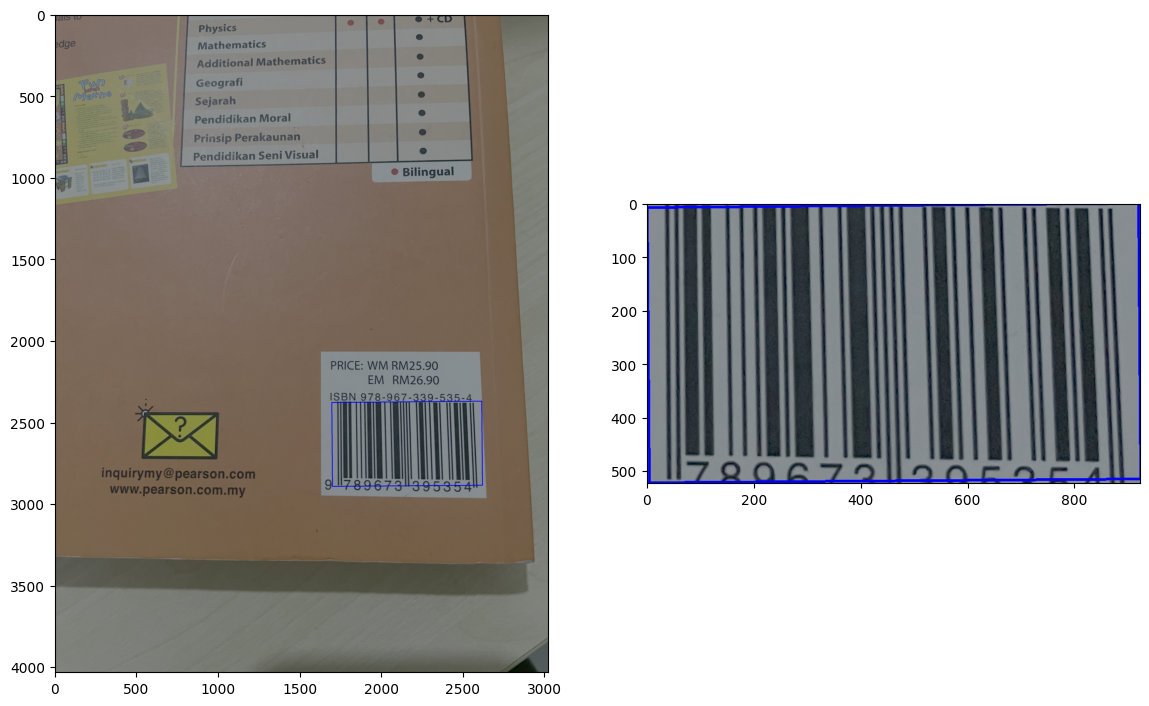

In [14]:
if contour is not None:
    rect = cv2.minAreaRect(contour)
    box = np.intp(cv2.boxPoints(rect))
    cropped = imutil.crop_roi2(image, box)
    scanner.imutil.draw_bounding_box2(image, box, imutil.BLUE_COLOR)
    plt.figure(figsize=(14, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(cropped, cmap='gray')
    print(f'Decoded barcode : {scanner.decode_barcode(cropped)}')
else:
    print('Box is null!')
    plt.imshow(dat['prev'], cmap='gray')